In [1]:
import cvxpy as cvx
import cvxopt
import networkx as nx
import numpy as np
import argparse
from typing import Tuple
# %matplotlib inline
import matplotlib.pyplot as plt
import random
from time import time
import os, sys
import subprocess
import re
import numpy as np
import pylab
from qiskit import Aer, BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import SPSA, COBYLA, L_BFGS_B
from qiskit.aqua.components.variational_forms import RY, RYRZ
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, QubitMappingType, TransformationType

In [2]:
import types
args = types.SimpleNamespace()

args.molecule='Be2' 
args.basis_set='ccpvtz' 
args.algorithm='VQE' 
args.transformation_type='TransformationType.FULL' 
args.qubitmapping_type='QubitMappingType.BRAVYI_KITAEV' 
args.two_qubit_reduce = True
args.vqe_optimizer='SPSA' 
args.vqe_max_iter=2
args.vqe_var_form='RY' 
args.vqe_depth=1 
args.vqe_entangler='linear' 
args.num_shots=100 
args.max_parallel_threads=10 
args.vqe_sim = True
args.vqe_aer = True
args.datapath='/pylon5/cc5phsp/cbernaci/mol2qpu'
args.random_seed=750 
args.vqe_opt_params = False

In [3]:
#def run_vqe_aer(args):

print("BEGIN RUN_VQE_AER")
print("args.molecule=", args.molecule)
print("args.datapath=", args.datapath)
#sys.exit("exiting now")

### READ IN MOLECULE
#FIXME: bring in molecules from file?
if args.molecule=='H2':
    molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
elif args.molecule=='LiH':
    molecule = 'Li .0 .0 -{0}; H .0 .0 {0}'
elif args.molecule=='Be2':
    molecule = 'Be .0 .0 -{0}; Be .0 .0 {0}'

start = 0.5  # Start distance
steps = 0    # Number of steps to increase by
energies = np.zeros(steps+1)
hf_energies = np.zeros(steps+1)
distances = np.zeros(steps+1)
aqua_globals.random_seed = args.random_seed

d = start

driver = PySCFDriver(molecule.format(d/2), basis=args.basis_set)
qmolecule = driver.run()
operator =  Hamiltonian(transformation=eval(args.transformation_type), 
                        qubit_mapping=eval(args.qubitmapping_type),  
                        two_qubit_reduction=args.two_qubit_reduce)

BEGIN RUN_VQE_AER
args.molecule= Be2
args.datapath= /pylon5/cc5phsp/cbernaci/mol2qpu


In [ ]:
qubitOp, aux_ops = operator.run(qmolecule)

In [ ]:
backend = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(circuit_caching=True, 
                                   backend=backend,
                                   backend_options={'max_parallel_threads': args.max_parallel_threads,                                                                             'max_parallel_experiments': 0, 
                                                    'shots': args.num_shots})
## optimizer
if args.vqe_optimizer=='SPSA':
    optimizer = SPSA(max_trials=200)
elif args.vqe_optimizer=='COBYLA':
    optimizer = COBYLA()
    optimizer.set_options(maxiter=args.vqe_max_iter)
elif args.vqe_optimizer=='L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=args.vqe_max_iter)
else:
    optimizer = COBYLA()
    optimizer.set_options(maxiter=args.vqe_max_iter)

## variational form
if args.vqe_var_form=='RY':
    var_form = RY(qubitOp.num_qubits, depth=args.vqe_depth, entanglement=args.vqe_entangler)   
elif args.vqe_var_form=='RYRZ':
    var_form = RYRZ(qubitOp.num_qubits, depth=args.vqe_depth, entanglement=args.vqe_entangler)

## VQE params
if args.vqe_opt_params:
    initial_point=np.load(args.vqe_opt_params_path+'._ret_opt_params.npy',allow_pickle=True, fix_imports=True)
    algo = VQE(qubitOp, var_form, optimizer, initial_point=initial_point)
else:
    algo = VQE(qubitOp, var_form, optimizer)

result = algo.run(quantum_instance)    
lines, result_op = operator.process_algorithm_result(result)

energies[i] = result['energy']
hf_energies[i] = result['hf_energy']
distances[i] = d

#print(type(result))
#print(dir(algo))
circ_opt = algo.get_optimal_circuit()
print(circ_opt)
#print('vqe WallTime:',computeWalltime(circ_opt))
print(' --- complete')
print('circuit_summary=', quantum_instance.circuit_summary)
print(algo.print_settings())
print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

#return result



In [31]:
result['algorithm_retvals']['eigvecs']
#results['eigvecs']
#type(results)
#eigvecs = results.get('eigvecs')


array([{'10': 9, '01': 91}], dtype=object)

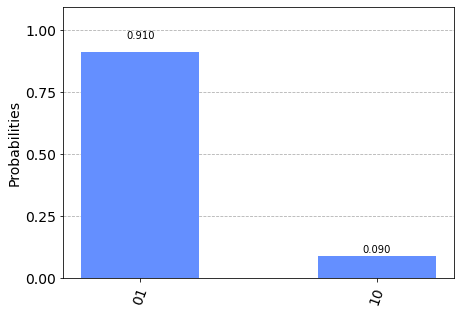

In [33]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(results['algorithm_retvals']['eigvecs'])

In [34]:
lines, resultA = operator.process_algorithm_result(results)

NameError: name 'operator' is not defined

In [ ]:
#results = run_vqe_aer(args) 